In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import spectrogram, lfilter, freqz, tf2zpk, butter

delka vstupniho souboru je 51098 hz
vzorkovaci frekvence je 16000 hz
minimum je -0.0758056640625
maximum je 0.105255126953125
[0.0000000e+00 6.2500000e-05 1.2500000e-04 ... 3.1934375e+00 3.1935000e+00
 3.1935625e+00]


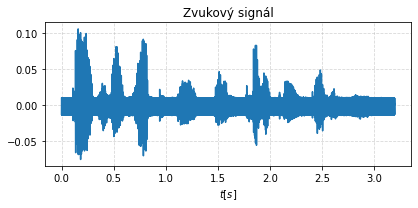

In [2]:
s, fs = sf.read('xkanko00.wav')
size = s.size
print("delka vstupniho souboru je", size, "hz")
print("vzorkovaci frekvence je", fs, "hz")
x = s
s = s[:size]
print("minimum je", s.min())
print("maximum je", s.max())
t = np.arange(size) / fs
print(t)
plt.figure(figsize=(6, 3))
plt.plot(t, s)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Zvukový signál')
plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

stredni hodnota je -1.3150545084629046e-05


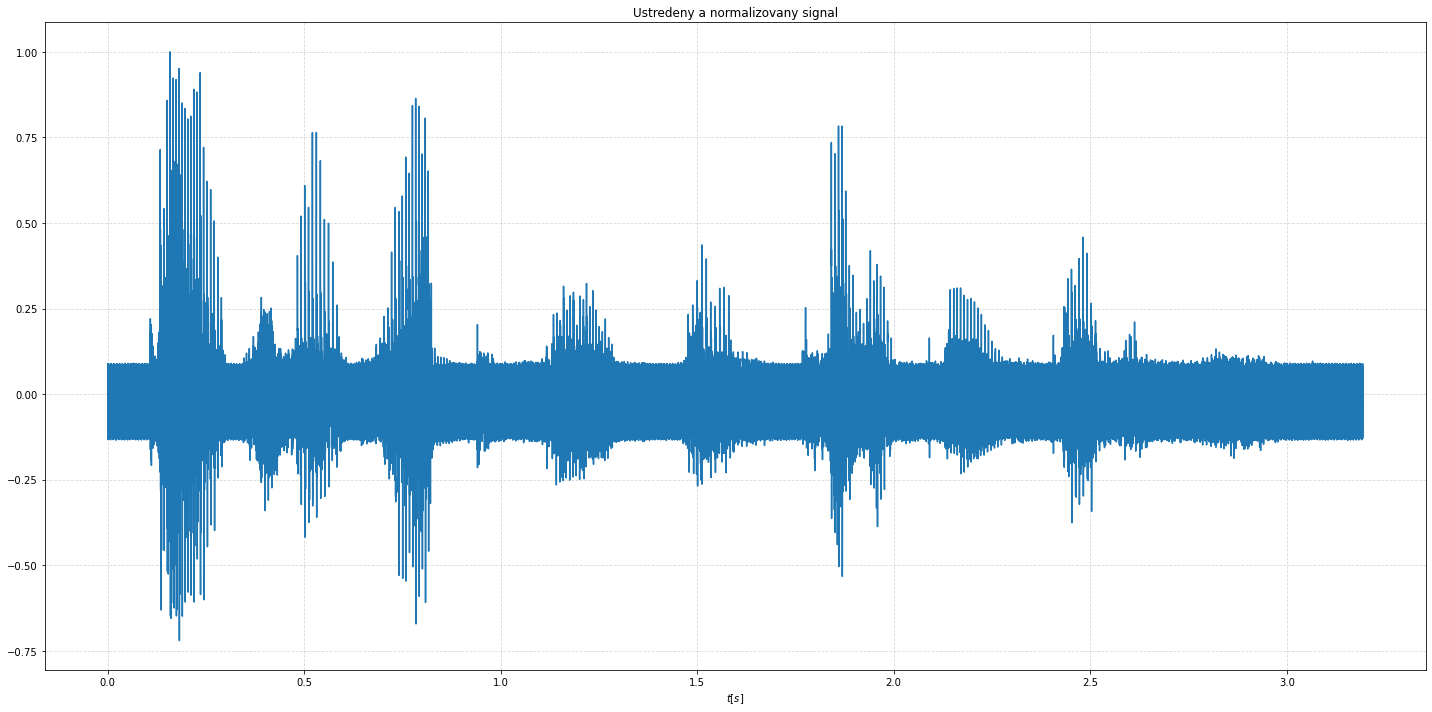

In [3]:
an = np.mean(s)
print("stredni hodnota je", an)
s = s - an
coef = 1 / s.max()
s = s * coef
t = np.arange(s.size) / fs
plt.figure(figsize=(20, 10))
plt.plot(t, s)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Ustredeny a normalizovany signal')
plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

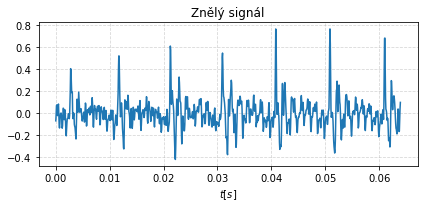

In [4]:
shift = 512
frame_len = 1024
x = np.array([s[i*shift:i*shift + frame_len] for i in range(len(s) //shift - frame_len//shift + 1)])
t = np.arange(len(x[0])) / fs
plt.figure(figsize=(6, 3))
plt.plot(t, x[15])
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Znělý signál')
plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

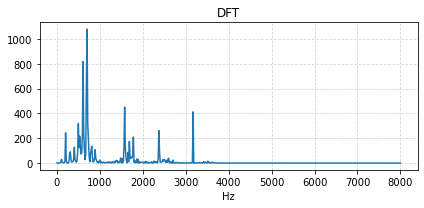

In [5]:
z = x[15]
N = z.shape[0]
n = np.arange(N)
k = n.reshape((N, 1))
M = np.exp(-2j * np.pi * k * n / N)
dftx = np.dot(M, z)
plt.figure(figsize=(6, 3))
r = np.abs(dftx)[:1024//2+1]**2
f_axis = np.arange(513)
plt.plot(f_axis/1024*fs, r)
plt.gca().set_xlabel('Hz')
plt.gca().set_title('DFT')
plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

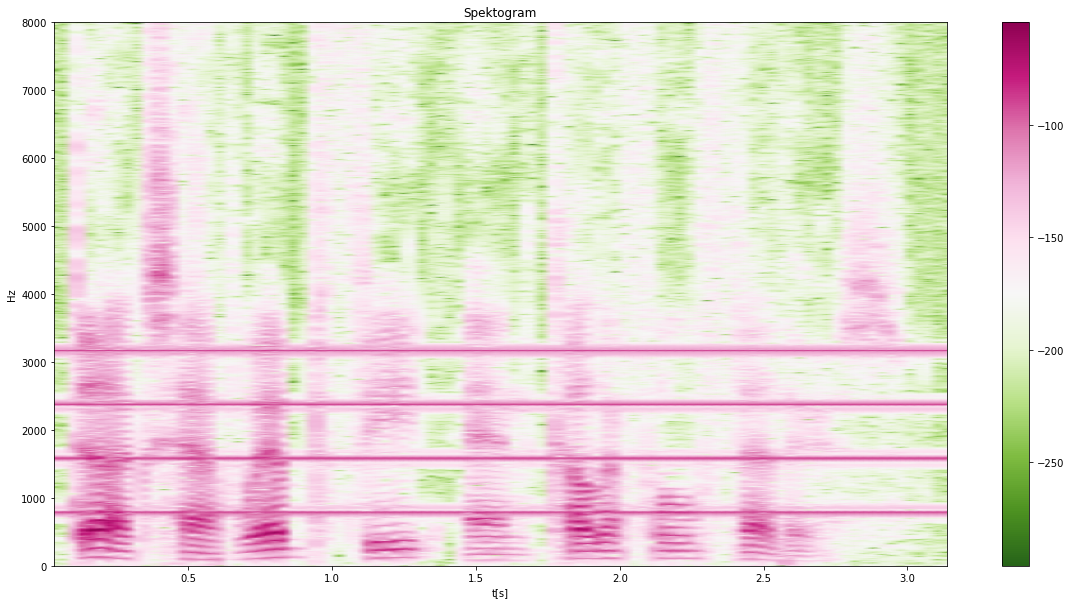

In [6]:
f, t, sgr = spectrogram(s, fs, nperseg=1024, noverlap=512)
sgr_log = 10 * np.log10(sgr**2)
plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, sgr_log, shading="gouraud", cmap='PiYG_r')
plt.title("Spektogram")
plt.colorbar()
plt.ylabel("Hz")
plt.xlabel("t[s]")
plt.show()

In [7]:
f1 = 795
f2 = 1590
f3 = 2385
f4 = 3180
noise = [0] * 4
noise[0] = 795
noise[1] = 1590
noise[2] = 2385
noise[3] = 3180
print("1. frekvence je ", f1)
print("2. frekvence je ", f2)
print("3. frekvence je ", f3)
print("4. frekvence je ", f4)

1. frekvence je  795
2. frekvence je  1590
3. frekvence je  2385
4. frekvence je  3180


In [8]:
arr = np.arange(size)/fs
out_cos1 = np.cos(2 * np.pi * f1 * arr)
out_cos2 = np.cos(2 * np.pi * f2 * arr)
out_cos3 = np.cos(2 * np.pi * f3 * arr)
out_cos4 = np.cos(2 * np.pi * f4 * arr)
out = out_cos1+out_cos2+out_cos3+out_cos4
sf.write('audio/4cos.wav', out, fs)

Text(0.5, 1.0, 'inpulsni odezva 4. filtru')

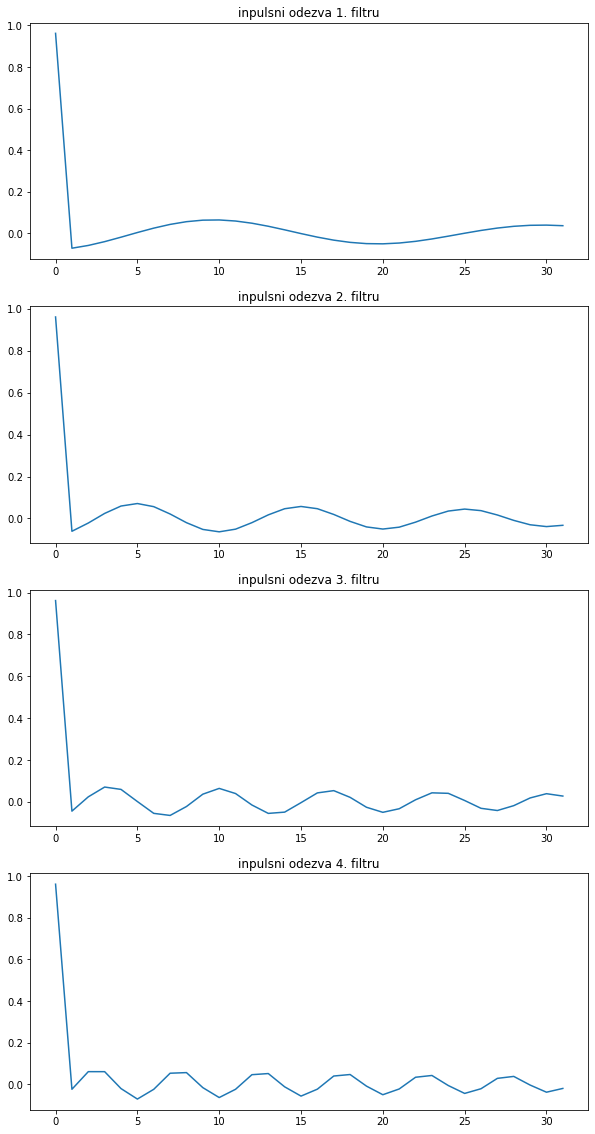

In [9]:
b_s = []
a_s = []
for i in range(4):
    lowcut = noise[i]-50
    highcut = noise[i]+50
    order = 3
    nyq = 0.5 *fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    
    b_s.append(b)
    a_s.append(a)
h = []
for j in range(4):
    N_imp = 32
    imp = [1, *np.zeros(N_imp-1)] # jednotkovy impuls
    h.append(lfilter(b_s[j], a_s[j], imp))
_, ax = plt.subplots(4, 1, figsize=(10,20))
ax[0].plot(h[0])
ax[0].set_title('inpulsni odezva 1. filtru')

ax[1].plot(h[1])
ax[1].set_title('inpulsni odezva 2. filtru')

ax[2].plot(h[2])
ax[2].set_title('inpulsni odezva 3. filtru')

ax[3].plot(h[3])
ax[3].set_title('inpulsni odezva 4. filtru')

Text(0.5, 1.0, 'Nuly a poly 4. filtru')

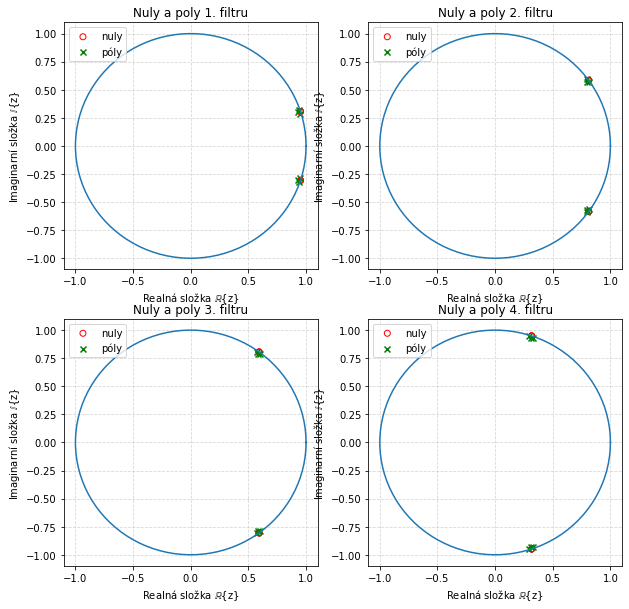

In [10]:
_, ax = plt.subplots(2, 2, figsize=(10,10))
ang = np.linspace(0, 2*np.pi,100)
z, p, k = tf2zpk(b_s[0], a_s[0])
ax[0, 0].plot(np.cos(ang), np.sin(ang))
ax[0, 0].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[0, 0].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

ax[0, 0].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
ax[0, 0].set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')
ax[0, 0].grid(alpha=0.5, linestyle='--')
ax[0, 0].legend(loc='upper left')
ax[0, 0].set_title("Nuly a poly 1. filtru")

z, p, k = tf2zpk(b_s[1], a_s[1])
ax[0, 1].plot(np.cos(ang), np.sin(ang))
ax[0, 1].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[0, 1].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

ax[0, 1].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
ax[0, 1].set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')
ax[0, 1].grid(alpha=0.5, linestyle='--')
ax[0, 1].legend(loc='upper left')
ax[0, 1].set_title("Nuly a poly 2. filtru")

z, p, k = tf2zpk(b_s[2], a_s[2])
ax[1, 0].plot(np.cos(ang), np.sin(ang))
ax[1, 0].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[1, 0].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

ax[1, 0].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
ax[1, 0].set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')
ax[1, 0].grid(alpha=0.5, linestyle='--')
ax[1, 0].legend(loc='upper left')
ax[1, 0].set_title("Nuly a poly 3. filtru")

z, p, k = tf2zpk(b_s[3], a_s[3])
ax[1, 1].plot(np.cos(ang), np.sin(ang))
ax[1, 1].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
ax[1, 1].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

ax[1, 1].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
ax[1, 1].set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')
ax[1, 1].grid(alpha=0.5, linestyle='--')
ax[1, 1].legend(loc='upper left')
ax[1, 1].set_title("Nuly a poly 4. filtru")

Text(0.5, 1.0, 'Argument frekvenční charakteristiky $\\mathrm{arg}\\ H(e^{j\\omega})$ 4. filtru')

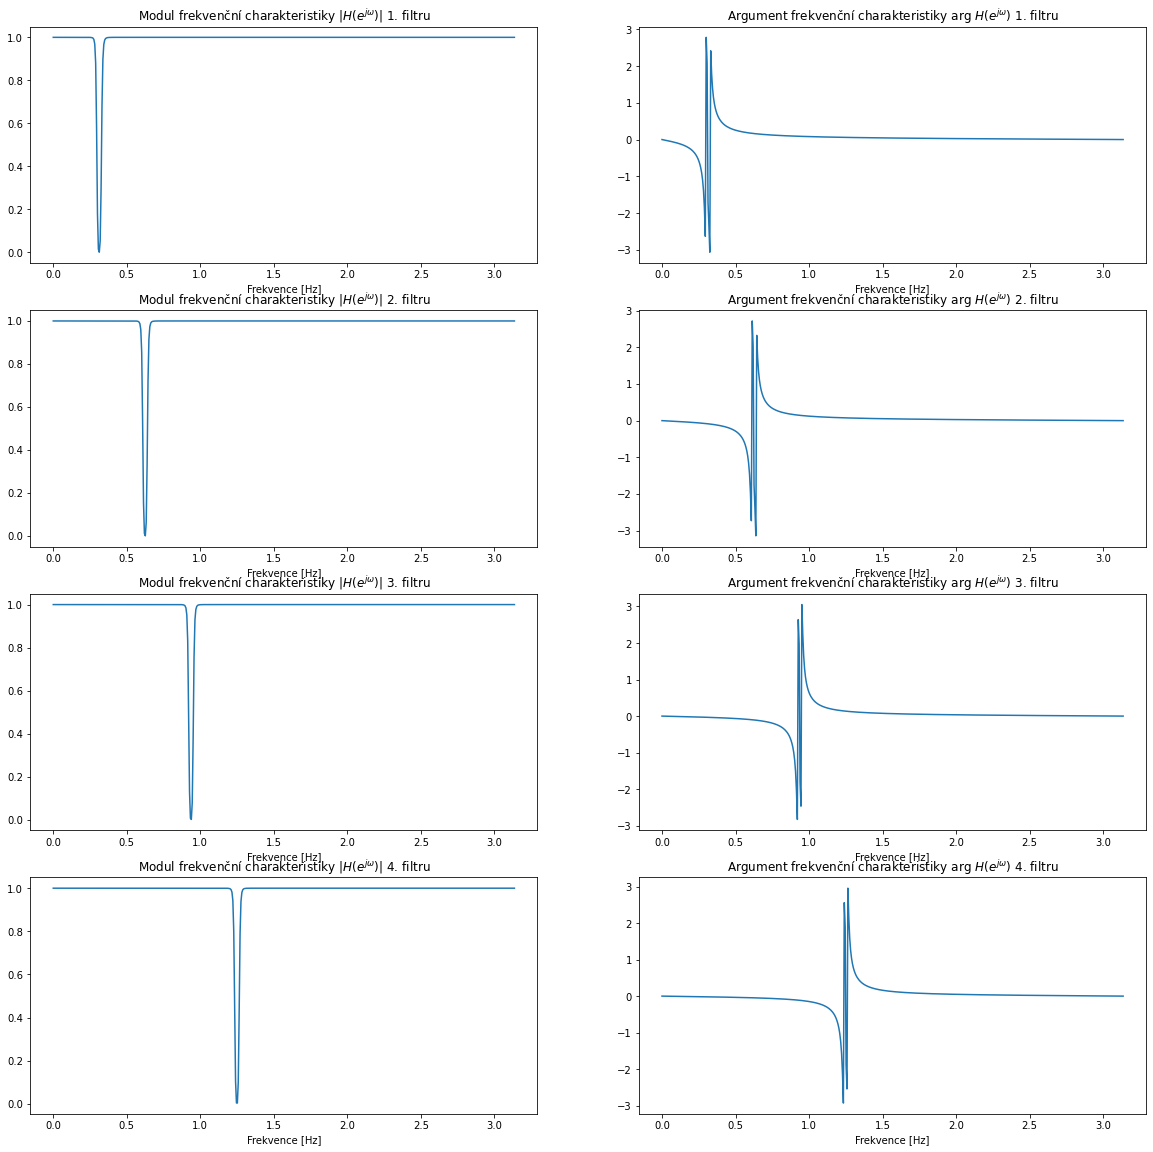

In [11]:
_, ax = plt.subplots(4, 2, figsize=(20,20))
w, H = freqz(b_s[0], a_s[0])
ax[0, 0].plot(w, np.abs(H))
ax[0, 0].set_xlabel('$t[s]$')
ax[0, 0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$ 1. filtru')

ax[0, 1].plot(w, np.angle(H))
ax[0, 1].set_xlabel('$t[s]$')
ax[0, 1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$ 1. filtru')

w, H = freqz(b_s[1], a_s[1])
ax[1, 0].plot(w, np.abs(H))
ax[1, 0].set_xlabel('$t[s]$')
ax[1, 0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$ 2. filtru')

ax[1, 1].plot(w, np.angle(H))
ax[1, 1].set_xlabel('$t[s]$')
ax[1, 1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$ 2. filtru')

w, H = freqz(b_s[2], a_s[2])
ax[2, 0].plot(w, np.abs(H))
ax[2, 0].set_xlabel('$t[s]$')
ax[2, 0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$ 3. filtru')

ax[2, 1].plot(w, np.angle(H))
ax[2, 1].set_xlabel('$t[s]$')
ax[2, 1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$ 3. filtru')

w, H = freqz(b_s[3], a_s[3])
ax[3, 0].plot(w, np.abs(H))
ax[3, 0].set_xlabel('$t[s]$')
ax[3, 0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$ 4. filtru')

ax[3, 1].plot(w, np.angle(H))
ax[3, 1].set_xlabel('$t[s]$')
ax[3, 1].set_title('Argument frekvenční charakteristiky $\mathrm{arg}\ H(e^{j\omega})$ 4. filtru')

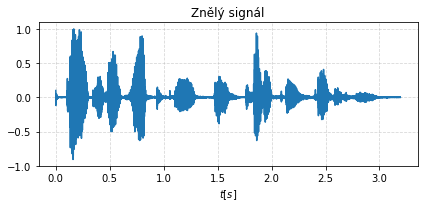

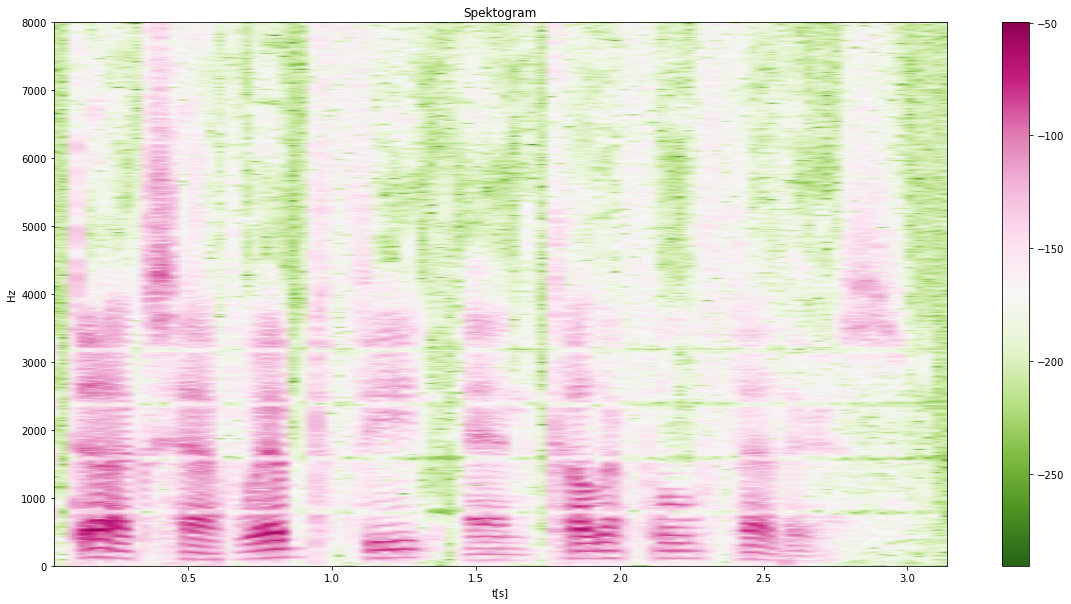

In [12]:
filtred = s
for i in range(4):
    filtred = lfilter(b_s[i], a_s[i], filtred)
    
coef = 1 / filtred.max()
filtred = filtred * coef

plt.figure(figsize=(6, 3))
t = np.arange(size)/fs
plt.plot(t, filtred)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Znělý signál')
plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

f, t, sgr = spectrogram(filtred, fs, nperseg=1024, noverlap=512)
sgr_log = 10 * np.log10(sgr**2)
plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, sgr_log, shading="gouraud", cmap='PiYG_r')
plt.title("Spektogram")
plt.colorbar()
plt.ylabel("Hz")
plt.xlabel("t[s]")
plt.show()

sf.write('audio/clean_bandstop.wav', filtred, fs)